## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.utils import resample

## Dataset

In [2]:
data = pd.read_csv('data/diabetes.csv')

In [3]:
data.info() # Information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
data.describe()  # Summary statistics

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
data.isnull().sum()  # Check for missing values

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## EDA

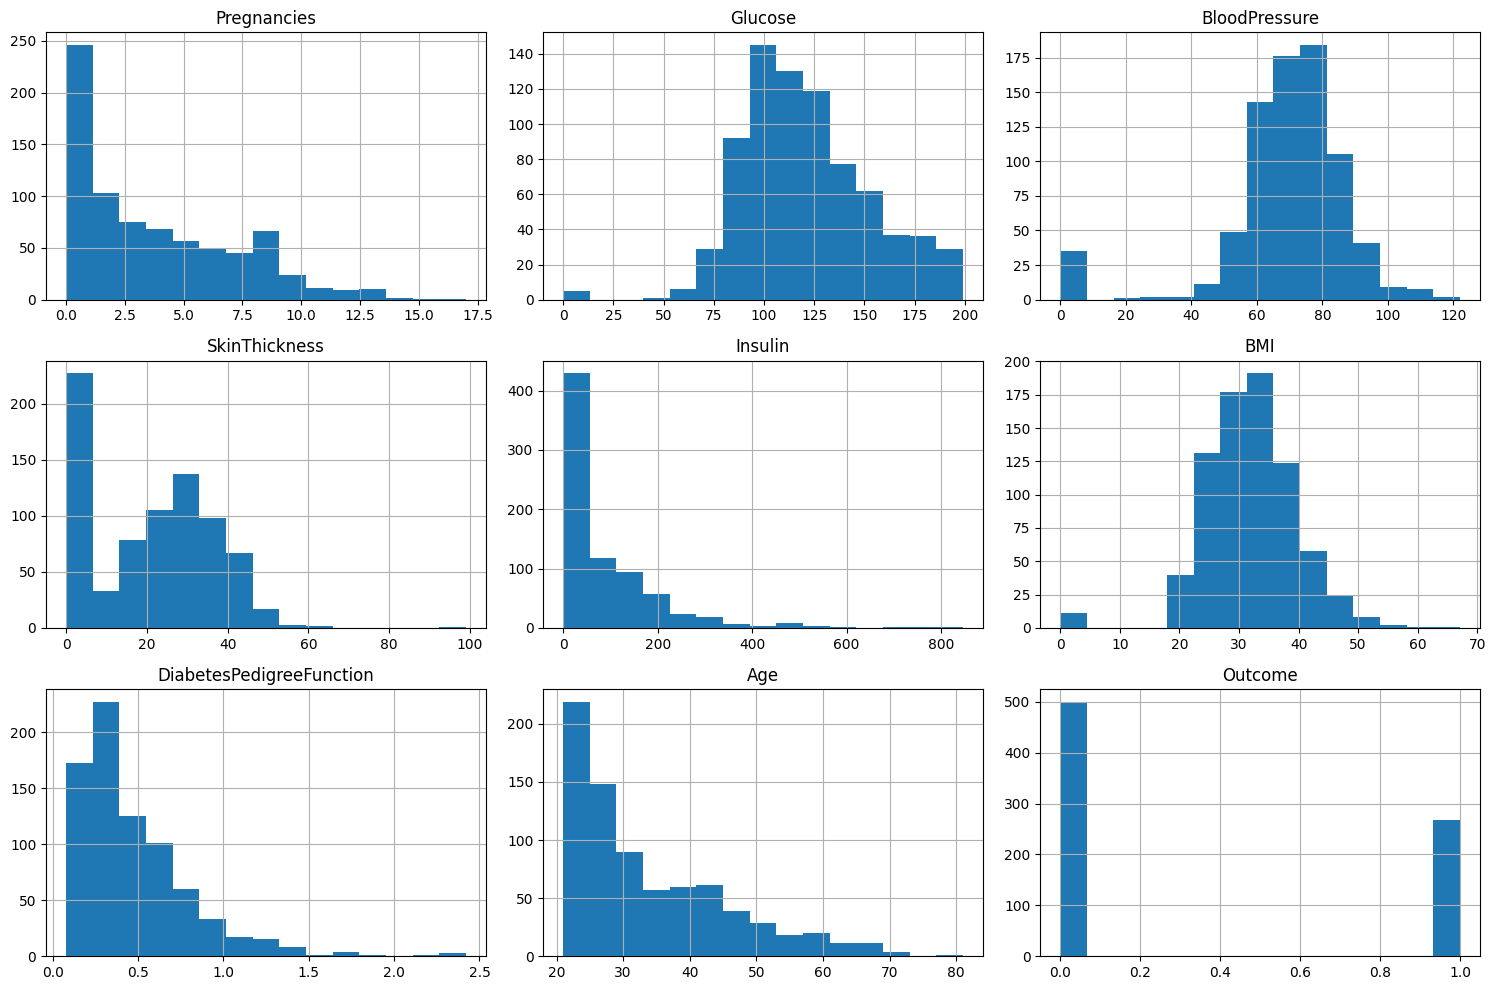

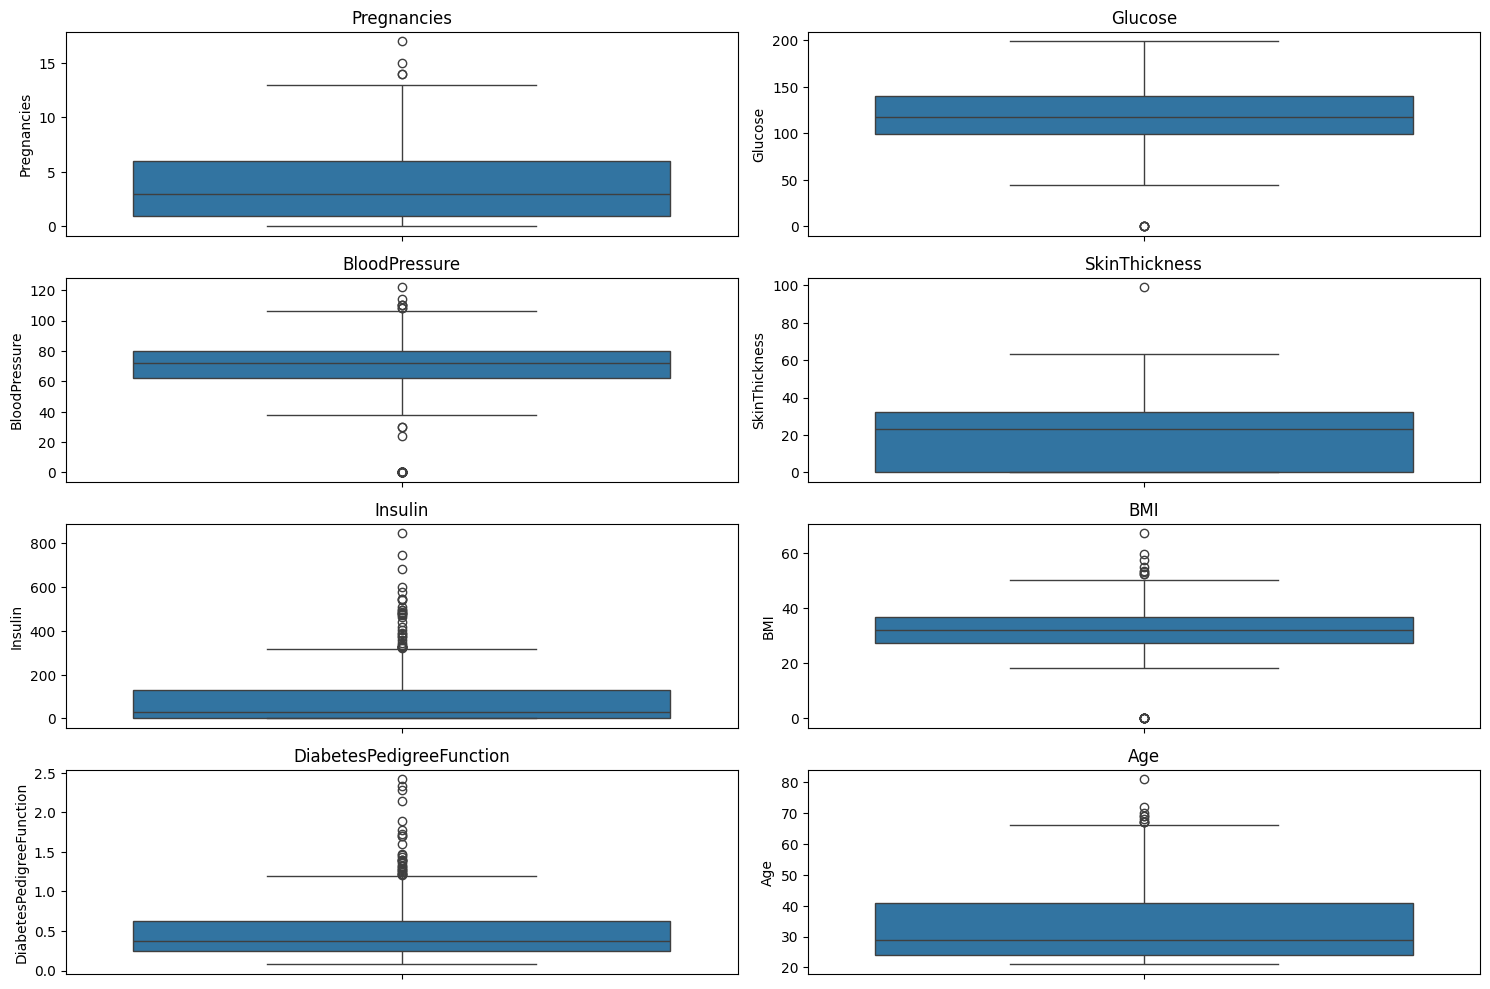

In [7]:
# Plot histograms for each feature
data.hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Box plots to analyze the distribution and detect outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(data.columns[:-1], 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data[column])
    plt.title(column)
plt.tight_layout()
plt.show()

Analysis:
1. Looking at the plot of glucose, blood pressure, skinthikness, and BMI, they are in normal distributions.
2. Data is imbalanced because we have 500 data entries of class 0, and around 250 entries for class 1.
3. We have some data points equal to zero in plots of glucose, blood pressure, skin thickness, BMI, and age that are not possible, meaning that they are missing.

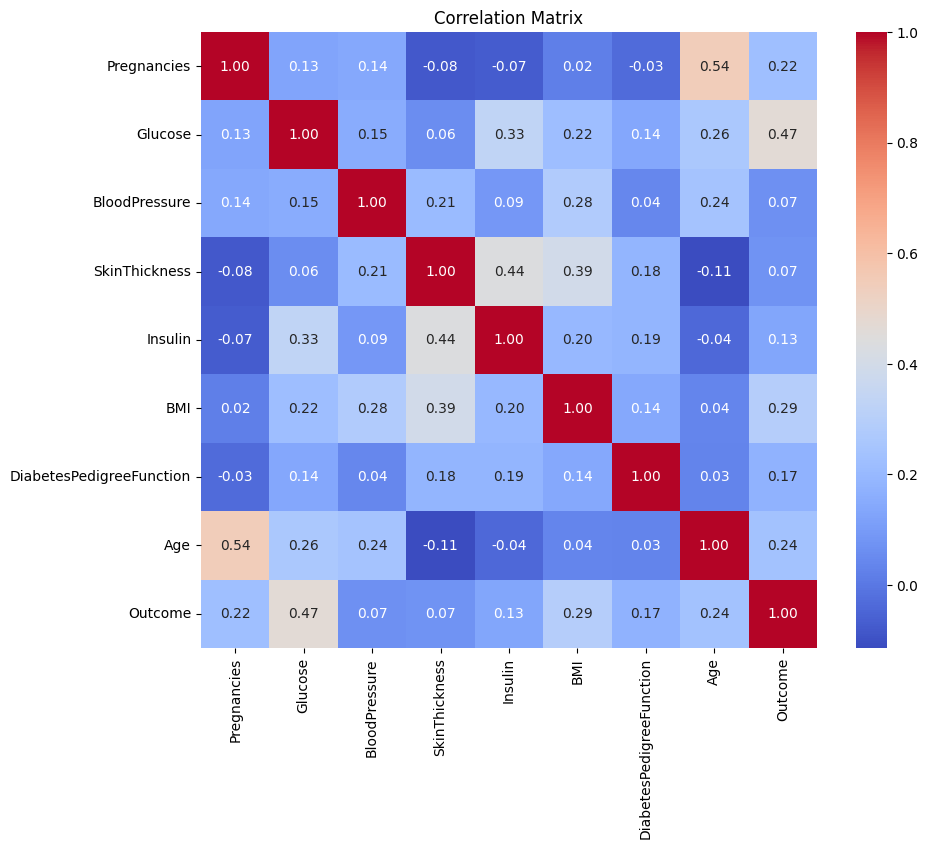

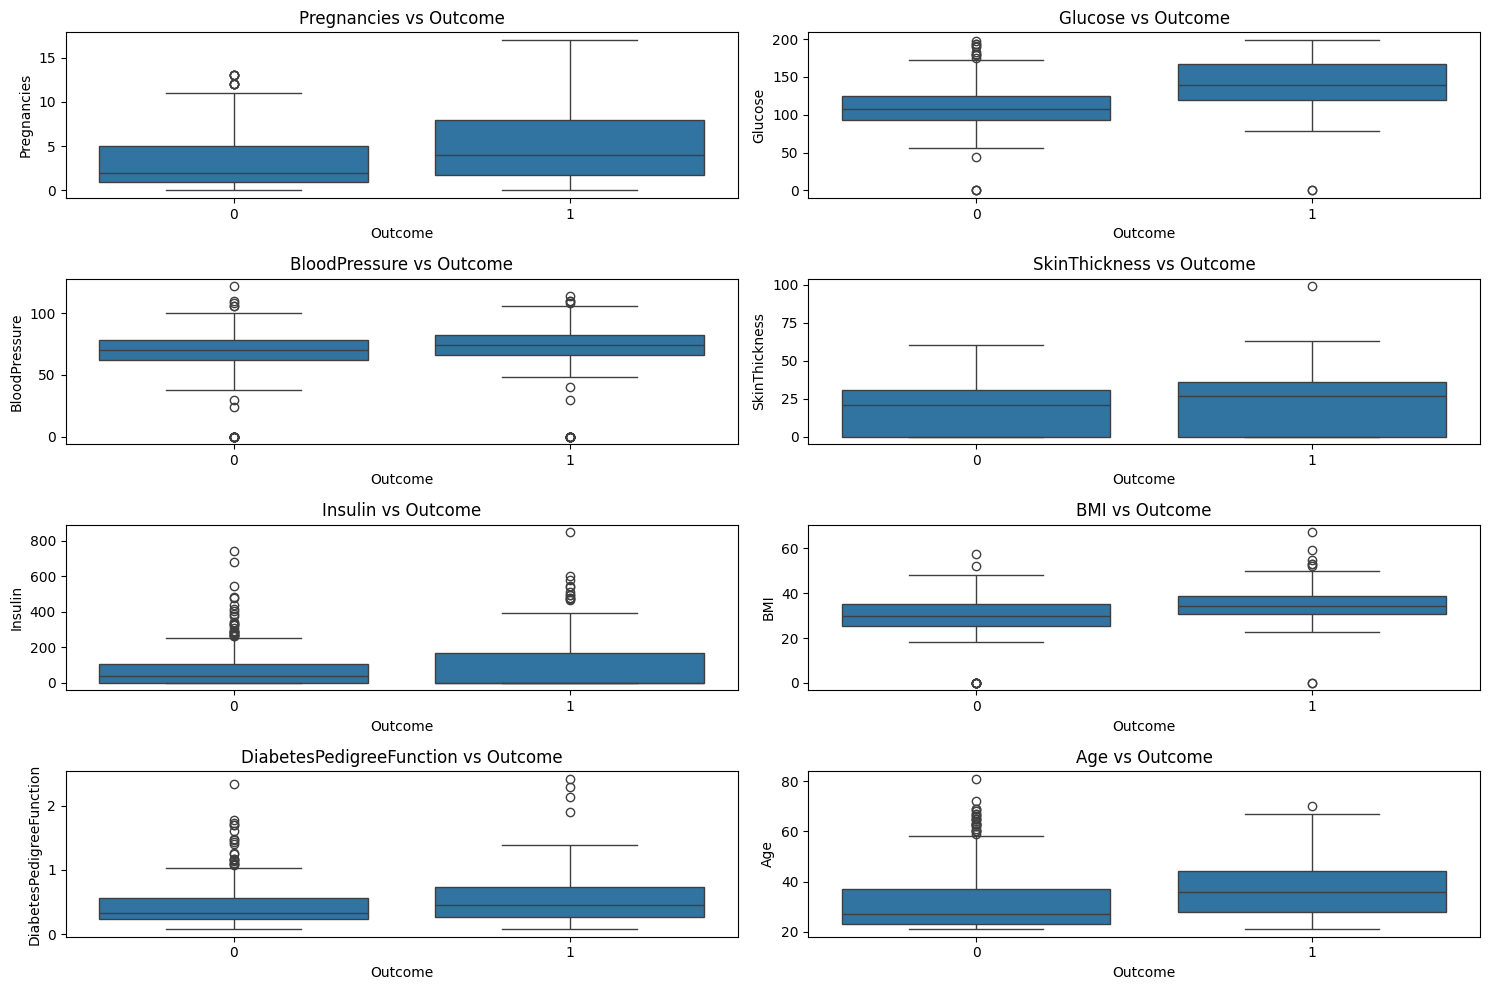

In [8]:
# Calculate correlation matrix
correlation_matrix = data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

# Analyze features with respect to the target variable using box plots
plt.figure(figsize=(15, 10))
for i, column in enumerate(data.columns[:-1], 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='Outcome', y=column, data=data)
    plt.title(f'{column} vs Outcome')
plt.tight_layout()
plt.show()

Analysis: 


Most correlated features with 'Outcome':
1. Gluscose: 47%
2. BMI: 29%
3. Age: 24%
4. Pregnancies: 22%

## Preprocessing

When preparing a dataset for analysis or machine learning, especially for a classification task like predicting diabetes outcomes, various preprocessing steps can enhance model performance and ensure data quality. Here are the usual preprocessing steps and their relevance to your diabetes dataset:

### Common Preprocessing Steps

1. **Handling Missing Values**:
   - **Methods**: Remove rows/columns with missing values or fill them with mean, median, or mode.
   - **Relevance**: We should fix the problem of zero data points in glucose, blood pressure, skin thickness, BMI, and age, as they are likely to be missing.

2. **Outlier Detection and Treatment**:
   - **Methods**: Identify outliers using statistical methods (like Z-scores or IQR) and either remove or transform them.
   - **Relevance**: Outliers can skew the data, especially in features like Glucose and BMI. Handling them is crucial for better model performance.

3. **Feature Scaling**:
   - **Methods**: Normalize (min-max scaling) or standardize (z-score scaling) the features.
   - **Relevance**: Features like Glucose and Insulin have different scales. Either normalization or standardization ensures that the model treats each feature equally. This step is taken in the following sections.

4. **Encoding Categorical Variables**:
   - **Methods**: Use one-hot encoding or label encoding for categorical features.
   - **Relevance**: Since we don't have any categorical variables, this is not needed.

5. **Feature Selection**:
   - **Methods**: Use techniques like correlation analysis, recursive feature elimination, or feature importance from models.
   - **Relevance**: Since Glucose (47%), BMI (29%), Age (24%), and Pregnancies (22%) are more correlated as opposed to other features, these are enough.

6. **Balancing Data**:
   - **Methods**: Over-sampling the minority class (e.g., SMOTE) or under-sampling the majority class, or creating synthetic samples for the minority class.
   - **Relevance**: Since dataset is imbalanced with 250 instances of class 1 (diabetic) and 500 instances of class 0 (non-diabetic), balancing is needed.

In [9]:
data_preprocessed = deepcopy(data)

In [10]:
# Step 1: Handling Missing Values
data_preprocessed[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = data_preprocessed[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, data_preprocessed[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].median())

In [11]:
data_preprocessed.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [12]:
# Step 2: Outlier Detection and Treatment
# Capping the outliers at the 1st and 99th percentile
for column in data_preprocessed.columns[:-1]:  # Exclude the target variable
    lower_bound = data_preprocessed[column].quantile(0.01)
    upper_bound = data_preprocessed[column].quantile(0.99)
    data_preprocessed[column].clip(lower=lower_bound, upper=upper_bound)

In [13]:
data_preprocessed

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,30.5,33.6,0.627,50,1
1,1,85,66,29,30.5,26.6,0.351,31,0
2,8,183,64,23,30.5,23.3,0.672,32,1
3,1,89,66,23,94.0,28.1,0.167,21,0
4,0,137,40,35,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180.0,32.9,0.171,63,0
764,2,122,70,27,30.5,36.8,0.340,27,0
765,5,121,72,23,112.0,26.2,0.245,30,0
766,1,126,60,23,30.5,30.1,0.349,47,1


In [14]:
# Step 5: Feature Selection

correlation = data_preprocessed.corr()['Outcome'].drop('Outcome').abs()
print(correlation.sort_values(ascending=False))

# Keep features with correlation above a certain threshold (e.g., 0.1)
selected_features = correlation[correlation > 0.2].index.tolist()
print("Selected features:", selected_features)

# Final DataFrame with selected features
data_preprocessed = data_preprocessed[selected_features + ['Outcome']]

Glucose                     0.492782
BMI                         0.312249
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.189065
DiabetesPedigreeFunction    0.173844
BloodPressure               0.165723
Insulin                     0.148457
Name: Outcome, dtype: float64
Selected features: ['Pregnancies', 'Glucose', 'BMI', 'Age']


In [15]:
data_preprocessed

,Pregnancies,Glucose,BMI,Age,Outcome
0,6,148,33.6,50,1
1,1,85,26.6,31,0
2,8,183,23.3,32,1
3,1,89,28.1,21,0
4,0,137,43.1,33,1
...,...,...,...,...,...
763,10,101,32.9,63,0
764,2,122,36.8,27,0
765,5,121,26.2,30,0
766,1,126,30.1,47,1


Here, we examine two methods of balancing data: 1) upsampling, and 2) downsampling.

In [16]:
# Step 6: Balancing Data

# Separate the majority and minority classes
data_preprocessed_majority = data_preprocessed[data['Outcome'] == 0]
data_preprocessed_minority = data_preprocessed[data['Outcome'] == 1]

# Over-sample the minority class
data_preprocessed_minority_upsampled = resample(data_preprocessed_minority, 
                                   replace=True,     # Sample with replacement
                                   n_samples=len(data_preprocessed_majority), # Match majority class size
                                   random_state=42)  # Set random state for reproducibility

# Combine the upsampled minority class with the majority class
data_preprocessed_upsampled = pd.concat([data_preprocessed_majority, data_preprocessed_minority_upsampled])

In [17]:
# Check the new class distribution
print("New class distribution after over-sampling:")
print(data_preprocessed_upsampled['Outcome'].value_counts())

New class distribution after over-sampling:
Outcome
0    500
1    500
Name: count, dtype: int64


In [18]:
# Under-sample the majority class
data_preprocessed_majority_downsampled = resample(data_preprocessed_majority, 
                                     replace=False,    # Sample without replacement
                                     n_samples=len(data_preprocessed_minority), # Match minority class size
                                     random_state=42) # Set random state for reproducibility

# Combine the downsampled majority class with the minority class
data_preprocessed_downsampled = pd.concat([data_preprocessed_majority_downsampled, data_preprocessed_minority])

In [19]:
# Check the new class distribution
print("New class distribution after under-sampling:")
print(data_preprocessed_downsampled['Outcome'].value_counts())

New class distribution after under-sampling:
Outcome
0    268
1    268
Name: count, dtype: int64


## Utils

In [20]:
def train_and_test_model(X_train, y_train, X_test):
    # Create a logistic regression model
    model = LogisticRegression(max_iter=1000)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict on training data
    y_train_pred = model.predict(X_train)
    
    # Predict on testing data
    y_test_pred = model.predict(X_test)

    return y_train_pred, y_test_pred

In [21]:
def print_result(y_train, y_train_pred, y_test, y_test_pred):
    # Confusion matrix, accuracy, and precision for training data
    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)

    # Confusion matrix, accuracy, and precision for testing data
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)

    # Display results
    print("Training Data Metrics:")
    print("Confusion Matrix:\n", conf_matrix_train)
    print("Accuracy:", accuracy_train)
    print("Precision:", precision_train)

    print("\nTesting Data Metrics:")
    print("Confusion Matrix:\n", conf_matrix_test)
    print("Accuracy:", accuracy_test)
    print("Precision:", precision_test)

In [22]:
def plot_conf_matrix(y_train, y_train_pred, y_test, y_test_pred):
    # Confusion matrix for training data
    conf_matrix_train = confusion_matrix(y_train, y_train_pred)

    # Confusion matrix for testing data
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)

    # Plotting the confusion matrix for training data
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Diabetic', 'Diabetic'], 
                yticklabels=['Non-Diabetic', 'Diabetic'])
    plt.title('Confusion Matrix - Training Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Plotting the confusion matrix for testing data
    plt.subplot(1, 2, 2)
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Diabetic', 'Diabetic'], 
                yticklabels=['Non-Diabetic', 'Diabetic'])
    plt.title('Confusion Matrix - Testing Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()

## Classification 

In [23]:
# Features and target
X_upsampled = data_preprocessed_upsampled.drop('Outcome', axis=1)
y_upsampled = data_preprocessed_upsampled['Outcome']

X_downsampled = data_preprocessed_downsampled.drop('Outcome', axis=1)
y_downsampled = data_preprocessed_downsampled['Outcome']

In [24]:
# Split the data into training and testing sets (80% train, 20% test)
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=42)
X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled = train_test_split(X_downsampled, y_downsampled, test_size=0.2, random_state=42)

In [25]:
y_train_pred_upsampled, y_test_pred_upsampled = train_and_test_model(X_train_upsampled, y_train_upsampled, X_test_upsampled)
y_train_pred_downsampled, y_test_pred_downsampled = train_and_test_model(X_train_downsampled, y_train_downsampled, X_test_downsampled)

In [26]:
print_result(y_train_upsampled, y_train_pred_upsampled, y_test_upsampled, y_test_pred_upsampled)
print("-----")
print_result(y_train_downsampled, y_train_pred_downsampled, y_test_downsampled, y_test_pred_downsampled)

Training Data Metrics:
Confusion Matrix:
 [[302 102]
 [118 278]]
Accuracy: 0.725
Precision: 0.7315789473684211

Testing Data Metrics:
Confusion Matrix:
 [[75 21]
 [22 82]]
Accuracy: 0.785
Precision: 0.7961165048543689
-----
Training Data Metrics:
Confusion Matrix:
 [[161  48]
 [ 58 161]]
Accuracy: 0.7523364485981309
Precision: 0.7703349282296651

Testing Data Metrics:
Confusion Matrix:
 [[48 11]
 [13 36]]
Accuracy: 0.7777777777777778
Precision: 0.7659574468085106


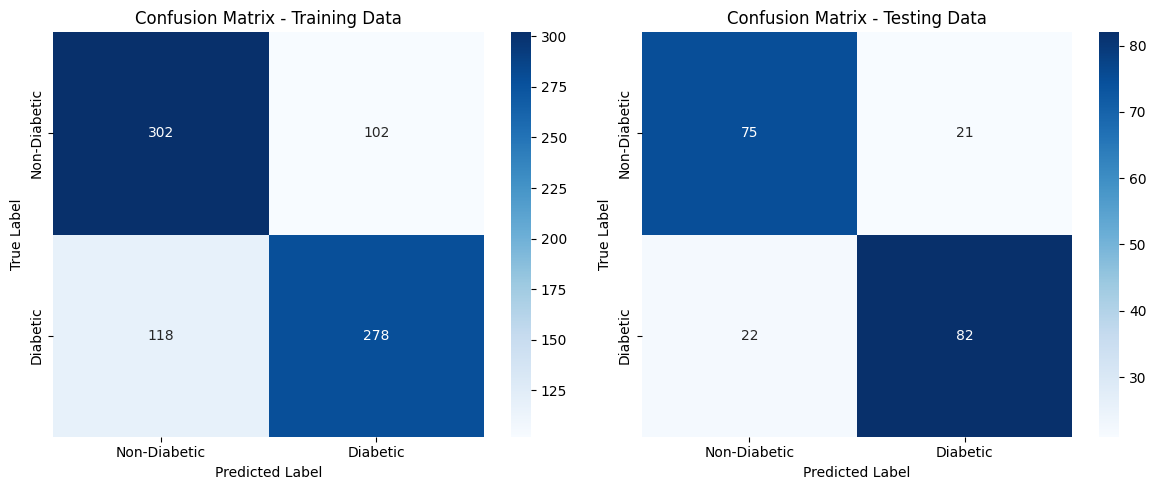

In [27]:
plot_conf_matrix(y_train_upsampled, y_train_pred_upsampled, y_test_upsampled, y_test_pred_upsampled)

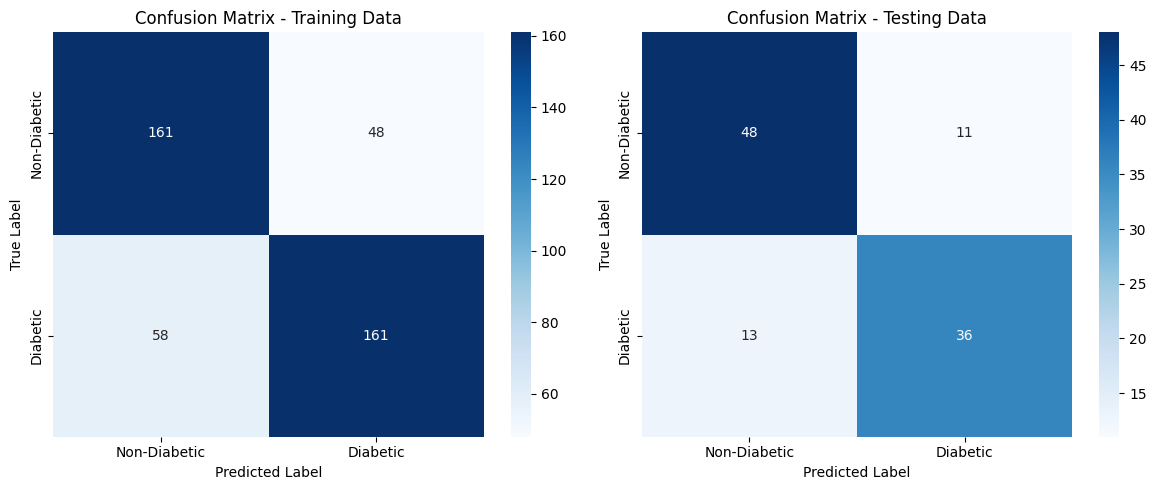

In [28]:
plot_conf_matrix(y_train_downsampled, y_train_pred_downsampled, y_test_downsampled, y_test_pred_downsampled)

## Normalization

In [29]:
# Step 3: Feature Scaling using Min-Max Normalization
scaler = MinMaxScaler()
features_upsampled = data_preprocessed_upsampled.drop('Outcome', axis=1)
features_downsampled = data_preprocessed_downsampled.drop('Outcome', axis=1)

target_upsampled = data_preprocessed_upsampled['Outcome'].values
target_downsampled = data_preprocessed_downsampled['Outcome'].values

features_upsampled_scaled = scaler.fit_transform(features_upsampled)
features_downsampled_scaled = scaler.fit_transform(features_downsampled)

# Create a new DataFrame with scaled features
data_preprocessed_upsampled_normalized = pd.DataFrame(features_upsampled_scaled, columns=features_upsampled.columns)
data_preprocessed_downsampled_normalized = pd.DataFrame(features_downsampled_scaled, columns=features_downsampled.columns)

data_preprocessed_upsampled_normalized['Outcome'] = target_upsampled
data_preprocessed_downsampled_normalized['Outcome'] = target_downsampled

In [30]:
data_preprocessed_upsampled_normalized.describe()

,Pregnancies,Glucose,BMI,Age,Outcome
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.246529,0.521877,0.298742,0.221217,0.50000
std,0.209805,0.191715,0.138352,0.193729,0.50025
min,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.058824,0.380645,0.200409,0.066667,0.00000
50%,0.176471,0.503226,0.290389,0.166667,0.50000
75%,0.411765,0.645161,0.376278,0.350000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.00000


In [31]:
data_preprocessed_downsampled_normalized.describe()

,Pregnancies,Glucose,BMI,Age,Outcome
count,536.000000,536.000000,536.000000,536.000000,536.000000
mean,0.241769,0.485259,0.304112,0.255926,0.500000
std,0.202441,0.221268,0.137801,0.222953,0.500467
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.323944,0.210123,0.078431,0.000000
50%,0.176471,0.457746,0.296524,0.196078,0.500000
75%,0.411765,0.626761,0.380368,0.392157,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
# Features and target
X_upsampled_normalized = data_preprocessed_upsampled_normalized.drop('Outcome', axis=1)
y_upsampled_normalized = data_preprocessed_upsampled_normalized['Outcome']

X_downsampled_normalized = data_preprocessed_downsampled_normalized.drop('Outcome', axis=1)
y_downsampled_normalized = data_preprocessed_downsampled_normalized['Outcome']

In [33]:
# Split the data into training and testing sets (80% train, 20% test)
X_train_upsampled_normalized, X_test_upsampled_normalized, y_train_upsampled_normalized, y_test_upsampled_normalized = train_test_split(X_upsampled_normalized, y_upsampled_normalized, test_size=0.2, random_state=42)
X_train_downsampled_normalized, X_test_downsampled_normalized, y_train_downsampled_normalized, y_test_downsampled_normalized = train_test_split(X_downsampled_normalized, y_downsampled_normalized, test_size=0.2, random_state=42)

In [34]:
y_train_pred_upsampled_normalized, y_test_pred_upsampled_normalized = train_and_test_model(X_train_upsampled_normalized, y_train_upsampled_normalized, X_test_upsampled_normalized)
y_train_pred_downsampled_normalized, y_test_pred_downsampled_normalized = train_and_test_model(X_train_downsampled_normalized, y_train_downsampled_normalized, X_test_downsampled_normalized)

In [35]:
print_result(y_train_upsampled_normalized, y_train_pred_upsampled_normalized, y_test_upsampled_normalized, y_test_pred_upsampled_normalized)
print("-----")
print_result(y_train_downsampled_normalized, y_train_pred_downsampled_normalized, y_test_downsampled_normalized, y_test_pred_downsampled_normalized)

Training Data Metrics:
Confusion Matrix:
 [[304 100]
 [121 275]]
Accuracy: 0.72375
Precision: 0.7333333333333333

Testing Data Metrics:
Confusion Matrix:
 [[74 22]
 [21 83]]
Accuracy: 0.785
Precision: 0.7904761904761904
-----
Training Data Metrics:
Confusion Matrix:
 [[163  46]
 [ 58 161]]
Accuracy: 0.7570093457943925
Precision: 0.7777777777777778

Testing Data Metrics:
Confusion Matrix:
 [[46 13]
 [14 35]]
Accuracy: 0.75
Precision: 0.7291666666666666


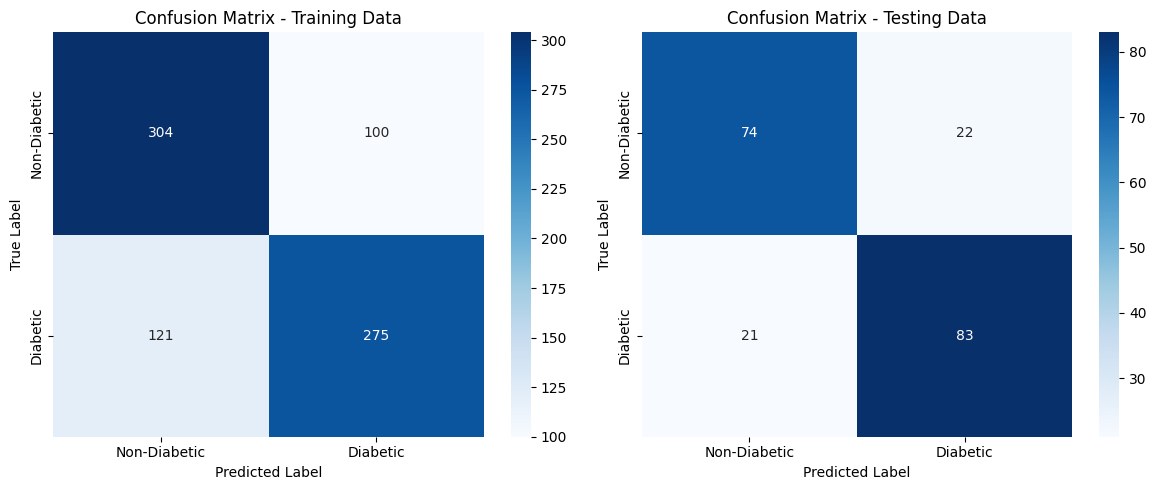

In [36]:
plot_conf_matrix(y_train_upsampled_normalized, y_train_pred_upsampled_normalized, y_test_upsampled_normalized, y_test_pred_upsampled_normalized)

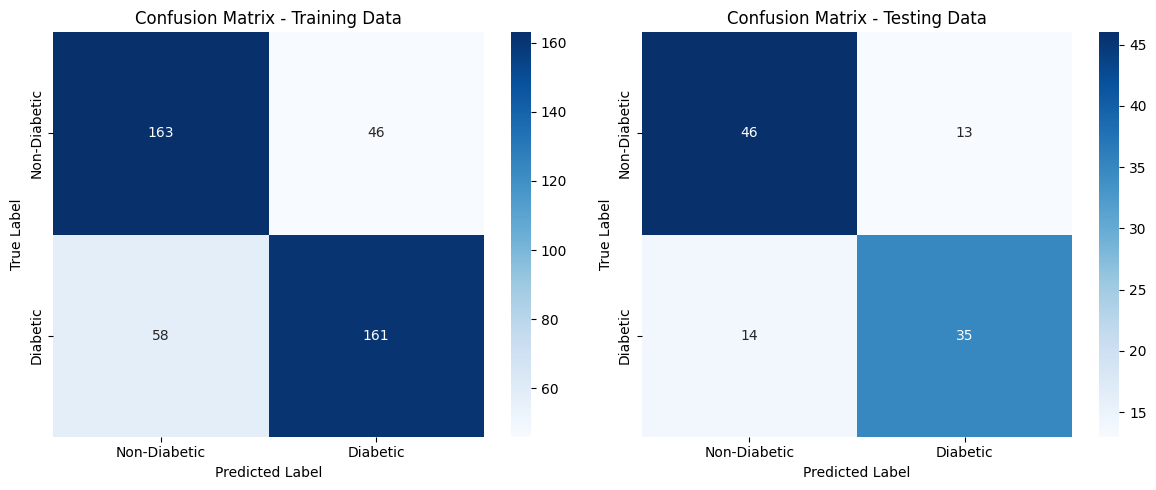

In [37]:
plot_conf_matrix(y_train_downsampled_normalized, y_train_pred_downsampled_normalized, y_test_downsampled_normalized, y_test_pred_downsampled_normalized)

## Standardization

In [38]:
# Step 3: Feature Scaling using Min-Max Normalization
scaler = StandardScaler()
features_upsampled = data_preprocessed_upsampled.drop('Outcome', axis=1)
features_downsampled = data_preprocessed_downsampled.drop('Outcome', axis=1)

target_upsampled = data_preprocessed_upsampled['Outcome'].values
target_downsampled = data_preprocessed_downsampled['Outcome'].values

features_upsampled_scaled = scaler.fit_transform(features_upsampled)
features_downsampled_scaled = scaler.fit_transform(features_downsampled)

# Create a new DataFrame with scaled features
data_preprocessed_upsampled_standardized = pd.DataFrame(features_upsampled_scaled, columns=features_upsampled.columns)
data_preprocessed_downsampled_standardized = pd.DataFrame(features_downsampled_scaled, columns=features_downsampled.columns)

data_preprocessed_upsampled_standardized['Outcome'] = target_upsampled
data_preprocessed_downsampled_standardized['Outcome'] = target_downsampled

In [39]:
data_preprocessed_upsampled_standardized.describe()

,Pregnancies,Glucose,BMI,Age,Outcome
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.00000
mean,9.947598e-17,-2.273737e-16,-3.694822e-16,-3.126388e-16,0.50000
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,0.50025
min,-1.175629e+00,-2.723511e+00,-2.160378e+00,-1.142458e+00,0.00000
25%,-8.951160e-01,-7.370460e-01,-7.111050e-01,-7.981623e-01,0.00000
50%,-3.340906e-01,-9.733681e-02,-6.041102e-02,-2.817195e-01,0.50000
75%,7.879602e-01,6.433791e-01,5.607059e-01,6.650922e-01,1.00000
max,3.593087e+00,2.495169e+00,5.071198e+00,4.021970e+00,1.00000


In [40]:
data_preprocessed_downsampled_standardized.describe()

,Pregnancies,Glucose,BMI,Age,Outcome
count,5.360000e+02,5.360000e+02,5.360000e+02,5.360000e+02,536.000000
mean,5.302558e-17,1.590767e-16,6.097941e-16,7.953837e-17,0.500000
std,1.000934e+00,1.000934e+00,1.000934e+00,1.000934e+00,0.500467
min,-1.195383e+00,-2.195132e+00,-2.208959e+00,-1.148965e+00,0.000000
25%,-9.045411e-01,-7.297295e-01,-6.827046e-01,-7.968523e-01,0.000000
50%,-3.228566e-01,-1.244546e-01,-5.512074e-02,-2.686831e-01,0.500000
75%,8.405124e-01,6.401032e-01,5.538955e-01,6.115989e-01,1.000000
max,3.748935e+00,2.328502e+00,5.054674e+00,3.340473e+00,1.000000


In [41]:
# Features and target
X_upsampled_standardized = data_preprocessed_upsampled_standardized.drop('Outcome', axis=1)
y_upsampled_standardized = data_preprocessed_upsampled_standardized['Outcome']

X_downsampled_standardized = data_preprocessed_downsampled_standardized.drop('Outcome', axis=1)
y_downsampled_standardized = data_preprocessed_downsampled_standardized['Outcome']

In [42]:
# Split the data into training and testing sets (80% train, 20% test)
X_train_upsampled_standardized, X_test_upsampled_standardized, y_train_upsampled_standardized, y_test_upsampled_standardized = train_test_split(X_upsampled_standardized, y_upsampled_standardized, test_size=0.2, random_state=42)
X_train_downsampled_standardized, X_test_downsampled_standardized, y_train_downsampled_standardized, y_test_downsampled_standardized = train_test_split(X_downsampled_standardized, y_downsampled_standardized, test_size=0.2, random_state=42)

In [43]:
y_train_pred_upsampled_standardized, y_test_pred_upsampled_standardized = train_and_test_model(X_train_upsampled_standardized, y_train_upsampled_standardized, X_test_upsampled_standardized)
y_train_pred_downsampled_standardized, y_test_pred_downsampled_standardized = train_and_test_model(X_train_downsampled_standardized, y_train_downsampled_standardized, X_test_downsampled_standardized)

In [44]:
print_result(y_train_upsampled_standardized, y_train_pred_upsampled_standardized, y_test_upsampled_standardized, y_test_pred_upsampled_standardized)
print("-----")
print_result(y_train_downsampled_standardized, y_train_pred_downsampled_standardized, y_test_downsampled_standardized, y_test_pred_downsampled_standardized)

Training Data Metrics:
Confusion Matrix:
 [[301 103]
 [118 278]]
Accuracy: 0.72375
Precision: 0.7296587926509186

Testing Data Metrics:
Confusion Matrix:
 [[75 21]
 [22 82]]
Accuracy: 0.785
Precision: 0.7961165048543689
-----
Training Data Metrics:
Confusion Matrix:
 [[161  48]
 [ 59 160]]
Accuracy: 0.75
Precision: 0.7692307692307693

Testing Data Metrics:
Confusion Matrix:
 [[48 11]
 [13 36]]
Accuracy: 0.7777777777777778
Precision: 0.7659574468085106


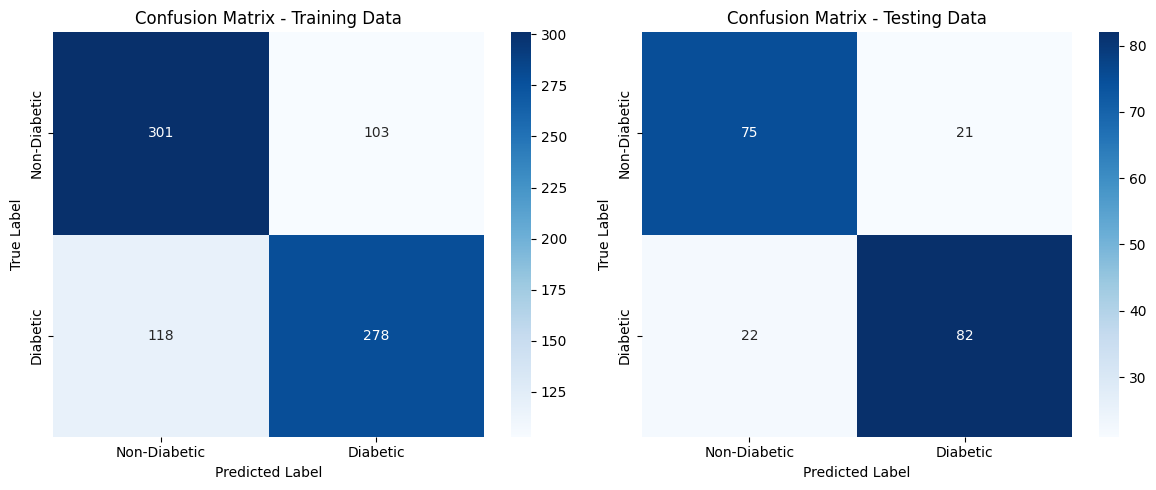

In [45]:
plot_conf_matrix(y_train_upsampled_standardized, y_train_pred_upsampled_standardized, y_test_upsampled_standardized, y_test_pred_upsampled_standardized)

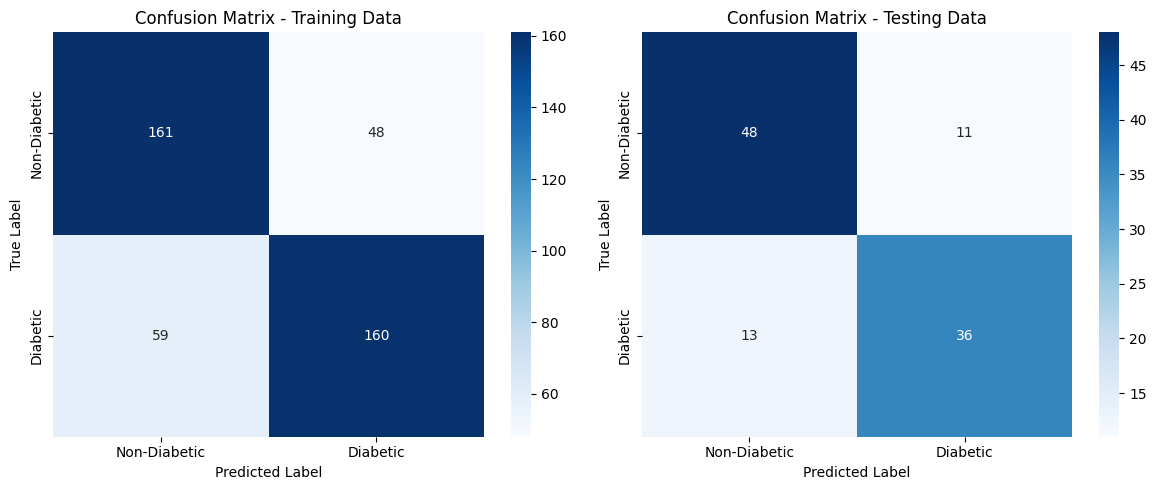

In [46]:
plot_conf_matrix(y_train_downsampled_standardized, y_train_pred_downsampled_standardized, y_test_downsampled_standardized, y_test_pred_downsampled_standardized)

## Comparison

### Upsampling vs. Downsampling

In [47]:
print_result(y_train_upsampled, y_train_pred_upsampled, y_test_upsampled, y_test_pred_upsampled)
print("-----")
print_result(y_train_downsampled, y_train_pred_downsampled, y_test_downsampled, y_test_pred_downsampled)

Training Data Metrics:
Confusion Matrix:
 [[302 102]
 [118 278]]
Accuracy: 0.725
Precision: 0.7315789473684211

Testing Data Metrics:
Confusion Matrix:
 [[75 21]
 [22 82]]
Accuracy: 0.785
Precision: 0.7961165048543689
-----
Training Data Metrics:
Confusion Matrix:
 [[161  48]
 [ 58 161]]
Accuracy: 0.7523364485981309
Precision: 0.7703349282296651

Testing Data Metrics:
Confusion Matrix:
 [[48 11]
 [13 36]]
Accuracy: 0.7777777777777778
Precision: 0.7659574468085106


In [48]:
print_result(y_train_upsampled_normalized, y_train_pred_upsampled_normalized, y_test_upsampled_normalized, y_test_pred_upsampled_normalized)
print("-----")
print_result(y_train_downsampled_normalized, y_train_pred_downsampled_normalized, y_test_downsampled_normalized, y_test_pred_downsampled_normalized)

Training Data Metrics:
Confusion Matrix:
 [[304 100]
 [121 275]]
Accuracy: 0.72375
Precision: 0.7333333333333333

Testing Data Metrics:
Confusion Matrix:
 [[74 22]
 [21 83]]
Accuracy: 0.785
Precision: 0.7904761904761904
-----
Training Data Metrics:
Confusion Matrix:
 [[163  46]
 [ 58 161]]
Accuracy: 0.7570093457943925
Precision: 0.7777777777777778

Testing Data Metrics:
Confusion Matrix:
 [[46 13]
 [14 35]]
Accuracy: 0.75
Precision: 0.7291666666666666


In [49]:
print_result(y_train_upsampled_standardized, y_train_pred_upsampled_standardized, y_test_upsampled_standardized, y_test_pred_upsampled_standardized)
print("-----")
print_result(y_train_downsampled_standardized, y_train_pred_downsampled_standardized, y_test_downsampled_standardized, y_test_pred_downsampled_standardized)

Training Data Metrics:
Confusion Matrix:
 [[301 103]
 [118 278]]
Accuracy: 0.72375
Precision: 0.7296587926509186

Testing Data Metrics:
Confusion Matrix:
 [[75 21]
 [22 82]]
Accuracy: 0.785
Precision: 0.7961165048543689
-----
Training Data Metrics:
Confusion Matrix:
 [[161  48]
 [ 59 160]]
Accuracy: 0.75
Precision: 0.7692307692307693

Testing Data Metrics:
Confusion Matrix:
 [[48 11]
 [13 36]]
Accuracy: 0.7777777777777778
Precision: 0.7659574468085106


Analysis:

Upsampling can result in higher metrics on the test set because it improves the model's ability to recognize minority class instances by providing more training examples. However, it may lead to lower training metrics due to the risk of overfitting and reduced diversity in the training set. Conversely, downsampling might enhance training metrics due to a more efficient learning process but can result in poorer test performance due to loss of information and bias toward the minority class. The key is to strike a balance that allows the model to generalize well while adequately learning from all classes.

#### 1. **Upsampling vs. Downsampling**
- **Upsampling**: This technique involves increasing the number of samples in the minority class by replicating existing samples or generating synthetic samples (e.g., using techniques like SMOTE). The idea is to balance the class distribution in the dataset, which can help the model learn better representations of the minority class.
  
- **Downsampling**: This technique reduces the number of samples in the majority class by randomly removing samples. While it helps to balance the class distribution, it can lead to a loss of potentially useful data.

#### 2. **Impact on Training Metrics**
- **Higher Metrics in the Test Set (Upsampling)**:
  - **Better Generalization**: Upsampling the minority class helps the model learn the characteristics of that class more effectively. As a result, when evaluated on the test set, which ideally contains a similar distribution to the upsampled training set, the model is likely to perform better. It can make more informed predictions about minority class instances, leading to higher precision, recall, and F1 scores.
  - **Fewer Misclassifications**: With a more balanced training dataset, the model is less likely to be biased towards the majority class, resulting in fewer misclassifications of the minority class in the test set.

- **Lower Metrics in the Train Set (Upsampling)**:
  - **Overfitting**: When upsampling, especially by replicating instances, the model may learn to memorize these specific samples rather than generalize well from the data. This can lead to overfitting, where the model performs well on the training data (which contains many repeated samples) but poorly on new, unseen data.
  - **Reduced Diversity**: Upsampling can reduce the diversity of examples in the training set, especially if it involves simple replication. The model may not encounter enough varied instances of the minority class, which can hurt its learning process.

#### 3. **Impact of Downsampling**
- **Higher Metrics in the Train Set (Downsampling)**:
  - **More Effective Training**: By removing excessive majority class samples, downsampling can make the training process more efficient, leading to higher training metrics. The model may achieve higher performance on the training set because it is better tuned to the remaining, more balanced data.
  
- **Lower Metrics in the Test Set (Downsampling)**:
  - **Loss of Information**: Downsampling can result in losing valuable information from the majority class. This can make the model less effective when it encounters real-world scenarios that often include instances from the majority class, leading to lower performance on the test set.
  - **Bias Towards Minority Class**: While downsampling helps with balance, it can lead the model to become biased toward the minority class due to the reduced representation of the majority class. When tested, the model might struggle with the more prevalent majority class instances.

### Standardization vs. Normalization vs. None

In [50]:
print_result(y_train_upsampled, y_train_pred_upsampled, y_test_upsampled, y_test_pred_upsampled)
print("-----")
print_result(y_train_upsampled_normalized, y_train_pred_upsampled_normalized, y_test_upsampled_normalized, y_test_pred_upsampled_normalized)
print("-----")
print_result(y_train_upsampled_standardized, y_train_pred_upsampled_standardized, y_test_upsampled_standardized, y_test_pred_upsampled_standardized)

Training Data Metrics:
Confusion Matrix:
 [[302 102]
 [118 278]]
Accuracy: 0.725
Precision: 0.7315789473684211

Testing Data Metrics:
Confusion Matrix:
 [[75 21]
 [22 82]]
Accuracy: 0.785
Precision: 0.7961165048543689
-----
Training Data Metrics:
Confusion Matrix:
 [[304 100]
 [121 275]]
Accuracy: 0.72375
Precision: 0.7333333333333333

Testing Data Metrics:
Confusion Matrix:
 [[74 22]
 [21 83]]
Accuracy: 0.785
Precision: 0.7904761904761904
-----
Training Data Metrics:
Confusion Matrix:
 [[301 103]
 [118 278]]
Accuracy: 0.72375
Precision: 0.7296587926509186

Testing Data Metrics:
Confusion Matrix:
 [[75 21]
 [22 82]]
Accuracy: 0.785
Precision: 0.7961165048543689


In [51]:
print_result(y_train_downsampled, y_train_pred_downsampled, y_test_downsampled, y_test_pred_downsampled)
print("-----")
print_result(y_train_downsampled_normalized, y_train_pred_downsampled_normalized, y_test_downsampled_normalized, y_test_pred_downsampled_normalized)
print("-----")
print_result(y_train_downsampled_standardized, y_train_pred_downsampled_standardized, y_test_downsampled_standardized, y_test_pred_downsampled_standardized)

Training Data Metrics:
Confusion Matrix:
 [[161  48]
 [ 58 161]]
Accuracy: 0.7523364485981309
Precision: 0.7703349282296651

Testing Data Metrics:
Confusion Matrix:
 [[48 11]
 [13 36]]
Accuracy: 0.7777777777777778
Precision: 0.7659574468085106
-----
Training Data Metrics:
Confusion Matrix:
 [[163  46]
 [ 58 161]]
Accuracy: 0.7570093457943925
Precision: 0.7777777777777778

Testing Data Metrics:
Confusion Matrix:
 [[46 13]
 [14 35]]
Accuracy: 0.75
Precision: 0.7291666666666666
-----
Training Data Metrics:
Confusion Matrix:
 [[161  48]
 [ 59 160]]
Accuracy: 0.75
Precision: 0.7692307692307693

Testing Data Metrics:
Confusion Matrix:
 [[48 11]
 [13 36]]
Accuracy: 0.7777777777777778
Precision: 0.7659574468085106


Analysis:

No significant difference when normalization and downsampling is used!